# Th analysis, October 2017

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

## Function definitions

In [2]:
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.) + const * np.exp((x-x0)/mean)

# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def reso_errors(values,errors):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return err_r, err_r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def gaussexpotext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        $\\bar x$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:3], values[4], *reso(values[0:3])))

-------------------------

# Save/load main event quantities

In [3]:
CAL_FACTOR = 1592/465600   # overall energy calibration factor
#CAL_FACTOR = 1592/328400   # MC
npmts = 11

evtfnames = ["data/npz_combined_4732.npz", "data/npz_combined_4735.npz"]
#evtfnames = ["data/npz_combined_MC4595.npz"]
#evtfnames = ["228th_arrays_r4717.npz", "228th_arrays_r4718_f0_3000.npz", "228th_arrays_r4718_f3000_6054.npz", 
#             "228th_arrays_r4719.npz", "228th_arrays_r4720.npz"]


## Load the information directly from files

In [4]:
A_eblob1 = []; A_eblob2 = []; A_emtrk = []; A_ntrks = []; A_lmtrk = []; A_nvox = []
A_Ec = []; A_Ec_avg = []; A_Ec_tau = []; A_Ec_geo = []; A_E0 = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []
for fname in evtfnames:

    fn = np.load(fname)
    A_eblob1 = np.concatenate((A_eblob1,fn['A_eblob1']))
    A_eblob2 = np.concatenate((A_eblob2,fn['A_eblob2']))
    A_emtrk  = np.concatenate((A_emtrk,fn['A_emtrk']))
    A_ntrks  = np.concatenate((A_ntrks,fn['A_ntrks']))
    A_lmtrk  = np.concatenate((A_lmtrk,fn['A_lmtrk']))
    A_nvox   = np.concatenate((A_nvox,fn['A_nvox']))
    A_Ec     = np.concatenate((A_Ec,fn['A_Ec']))
    A_Ec_avg = np.concatenate((A_Ec_avg,fn['A_Ec_avg']))
    A_Ec_tau = np.concatenate((A_Ec_tau,fn['A_Ec_tau']))
    A_Ec_geo = np.concatenate((A_Ec_geo,fn['A_Ec_geo']))
    A_E0     = np.concatenate((A_E0,fn['A_E0']))
    A_xavg   = np.concatenate((A_xavg,fn['A_xavg']))
    A_yavg   = np.concatenate((A_yavg,fn['A_yavg']))
    A_zavg   = np.concatenate((A_zavg,fn['A_zavg']))
    A_ravg   = np.concatenate((A_ravg,fn['A_ravg']))

--------------------------

# Distributions and analysis of all events
At this point we have arrays containing key information from each event.  Here we construct plots from those arrays.<br>

`A_eblob1`  -- energy of blob1 (most energetic) as obtained from Paolina analysis<br>
`A_eblob2`  -- energy of blob2 (least energetic) as obtained from Paolina analysis<br>
`A_emtrk`   -- energy of most energetic Paolina track in event<br>
`A_lmtrk`   -- length of most energetic Paolina track in event<br>
`A_ntrks`   -- number of tracks in the event<br>
`A_nvox`    -- number of voxels in the event<br>
`A_Ec`      -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Ec_avg`  -- corrected energy (lifetime by average $z$, $(x,y)$ by average $x$ and $y$)<br>
`A_Ec_tau`  -- corrected energy (lifetime only, by hit)<br>
`A_Ec_geo`  -- corrected energy (geometry only, by hit)<br>
`A_E0`      -- uncorrected energy<br>
`A_xavg`    -- average reconstructed $x$-coordinate of event<br>
`A_yavg`    -- average reconstructed $y$-coordinate of event<br>
`A_zavg`    -- average reconstructed $z$-coordinate of event<br>
`A_ravg`    -- average $r = \sqrt{x^2 + y^2}$ of event<br>

In [5]:
# Key variables in constructing cuts.
Emin = 0*npmts; Emax = 80000*npmts       # basic cut energy range
eb1_low = 1000; eb1_high = 1275          # blob plot intervals
eb2_low = 1520; eb2_high = 1660
eb3_low = 1800; eb3_high = 2500
Emin_emtrk = 500/CAL_FACTOR; Emax_emtrk = 2500/CAL_FACTOR    # emtrk basic energy cut range

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
C_basic       = (A_E0 > Emin) & (A_E0 < Emax) & (A_Ec > Emin) & (A_Ec < Emax) & (A_Ec_tau > Emin) & (A_Ec_tau < Emax) & (A_Ec_avg > Emin) & (A_Ec_avg < Emax) & (A_zavg < 580)
C_wide        = C_basic & (A_ravg < 150) & (A_zavg > 50) & (A_zavg < 500)
C_tight       = C_wide & (A_ravg < 100) & (A_zavg > 50) & (A_zavg < 150) 
C_blobs       = (A_eblob2*CAL_FACTOR < 200)
C_tightwblobs = C_tight & C_blobs
C_widewblobs  = C_wide & C_blobs

# Cuts defining different spectral regions
C_trks                 = (A_lmtrk > 100) & (A_ntrks == 1)
C_basic_emtrk          = C_trks & (A_emtrk > Emin_emtrk) & (A_emtrk < Emax_emtrk)
C_Ec_regionprepeak     = C_basic_emtrk & (A_Ec*CAL_FACTOR > eb1_low) & (A_Ec*CAL_FACTOR < eb1_high)
C_Ec_regionpeak        = C_basic_emtrk & (A_Ec*CAL_FACTOR > eb2_low) & (A_Ec*CAL_FACTOR < eb2_high)
C_Ec_regionpostpeak    = C_basic_emtrk & (A_Ec*CAL_FACTOR > eb3_low) & (A_Ec*CAL_FACTOR < eb3_high)
C_emtrk_regionprepeak  = C_basic_emtrk & (A_emtrk*CAL_FACTOR > eb1_low) & (A_emtrk*CAL_FACTOR < eb1_high)
C_emtrk_regionpeak     = C_basic_emtrk & (A_emtrk*CAL_FACTOR > eb2_low) & (A_emtrk*CAL_FACTOR < eb2_high)
C_emtrk_regionpostpeak = C_basic_emtrk & (A_emtrk*CAL_FACTOR > eb3_low) & (A_emtrk*CAL_FACTOR < eb3_high)

print("Events in key quantities: {0}".format(len(A_Ec)))

Events in key quantities: 956072


## Energy spectra using different corrections

[ 541274.93469941  158147.58999488  114399.81035342 ...,   86708.64663104
  190873.48481534  161839.67542836]


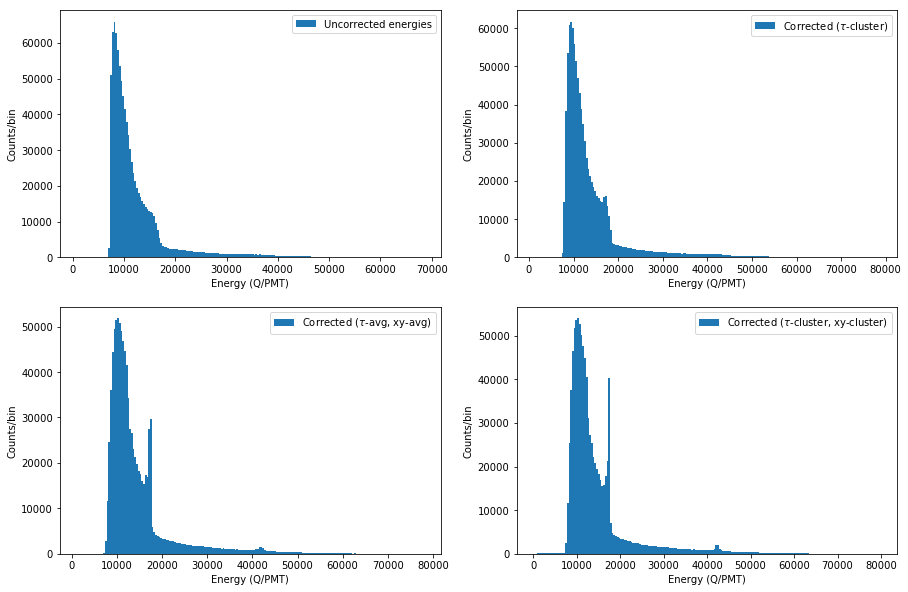

In [6]:
cuts_espectra = C_basic
print(A_Ec_avg)
ebins = 200

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_E0[cuts_espectra]/npmts,bins=ebins,label='Uncorrected energies')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_Ec_tau[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(A_Ec_avg[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-avg, xy-avg)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(A_Ec[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster, xy-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

## Paolina tracks and voxel distributions

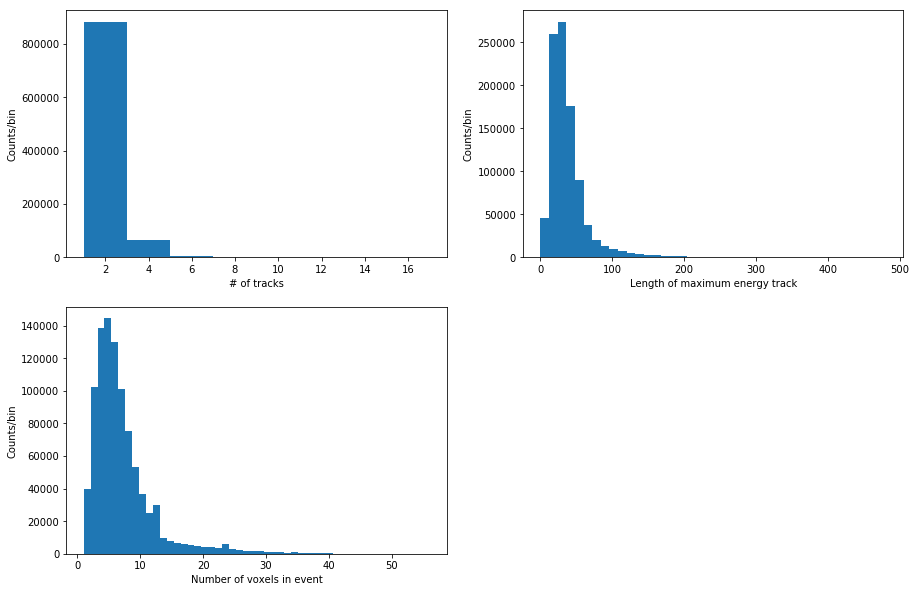

In [7]:
cuts_trkplots = C_basic
ntrk_bins = 8
lmtrk_bins = 40
nvox_bins = 50

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_ntrks[cuts_trkplots],bins=ntrk_bins)
plt.xlabel('# of tracks')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_lmtrk[cuts_trkplots],bins=lmtrk_bins)
plt.xlabel('Length of maximum energy track')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(223)
plt.hist(A_nvox[cuts_trkplots],bins=nvox_bins)
plt.xlabel('Number of voxels in event')
plt.ylabel('Counts/bin')

## Blob energy plots

Number of events I1 (1000.00 keV, 1275.00 keV): 4837
Number of events I2 (1520.00 keV, 1660.00 keV): 2577
Number of events I3 (1800.00 keV, 2500.00 keV): 1486
Some long events in peak region above 300 keV (2-blobs):
[1515, 85700, 118946, 157963, 190802, 209021, 287207, 306799, 310455, 322730, 365911, 397510, 407247, 495162, 507250, 512541, 512927, 557187, 670820, 740474]
Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):
[97, 7561, 9898, 11133, 11634, 14540, 16642, 18150, 18156, 28043, 31256, 31908, 35886, 40447, 40914, 41419, 41816, 45213, 48108, 48690]


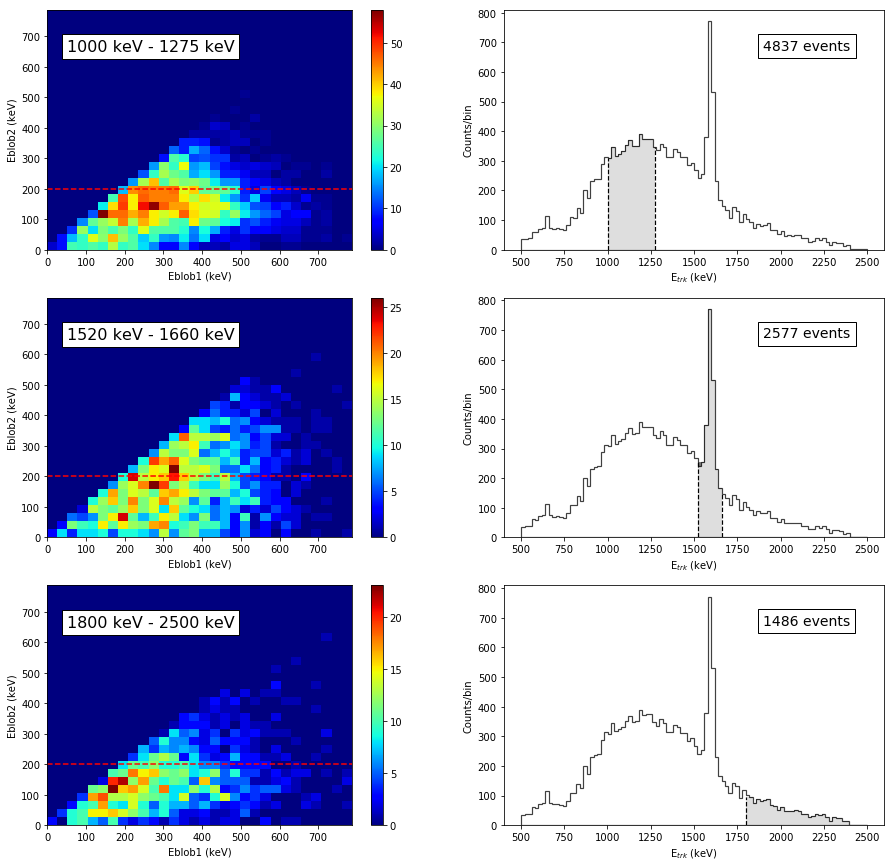

In [13]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 30

fig = plt.figure(3)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# label locations
label_blobhist_x = 50
label_blobhist_y = 650
label_evthist_x = 1900

# horizontal reference line
hline_y = 200

# cuts
cuts_1 = C_emtrk_regionprepeak
cuts_2 = C_emtrk_regionpeak
cuts_3 = C_emtrk_regionpostpeak

print("Number of events I1 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb1_low,eb1_high,len(A_eblob1[cuts_1])))
print("Number of events I2 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb2_low,eb2_high,len(A_eblob1[cuts_2])))
print("Number of events I3 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb3_low,eb3_high,len(A_eblob1[cuts_3])))

pltevts_2e = cuts_2 & (A_eblob2*CAL_FACTOR > 300) & (A_lmtrk > 180)
pltevts_1e = cuts_2 & (A_eblob2*CAL_FACTOR >= 40) & (A_eblob2*CAL_FACTOR <= 200) & (A_lmtrk > 180)
print("Some long events in peak region above 300 keV (2-blobs):")
print([i for i,x in enumerate(pltevts_2e) if x][0:20])
print("Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):")
print([i for i,x in enumerate(pltevts_1e) if x][0:20])

# -----------------------------------------------
# interval 1
ax1 = fig.add_subplot(321)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_1]*CAL_FACTOR, A_eblob1[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax1.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low,eb1_high), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

ax2 = fig.add_subplot(322)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb1_low
high_cut = eb1_high
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax2.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_1])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax2.set_xlabel('E$_{trk}$ (keV)')
ax2.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 2
ax3 = fig.add_subplot(323)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_2]*CAL_FACTOR, A_eblob1[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax3.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low,eb2_high), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

ax4 = fig.add_subplot(324)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb2_low
high_cut = eb2_high
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax4.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_2])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax4.set_xlabel('E$_{trk}$ (keV)')
ax4.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 3
ax5 = fig.add_subplot(325)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_3]*CAL_FACTOR, A_eblob1[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax5.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low,eb3_high), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent5 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp5 = ax5.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax5.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax5.set_xlabel("Eblob1 (keV)")
ax5.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp5)

ax6 = fig.add_subplot(326)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb3_low
high_cut = eb3_high
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax6.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_3])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax6.set_xlabel('E$_{trk}$ (keV)')
ax6.set_ylabel('Counts/bin')

## Radial and z distributions

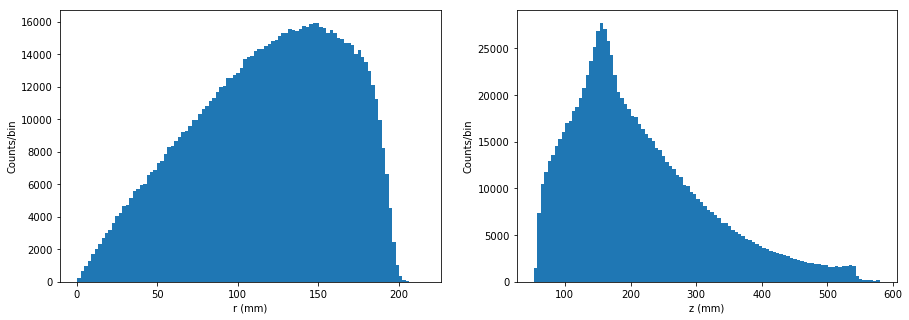

In [9]:
# Distributions in r and z
cuts_rz = C_basic


fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# event distribution in R
ax1 = fig.add_subplot(121);
plt.hist(A_ravg[cuts_rz],bins=100)
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

# event distribution in z
ax2 = fig.add_subplot(122);
plt.hist(A_zavg[cuts_rz],bins=100)
plt.xlabel('z (mm)')
plt.ylabel('Counts/bin')

## x-y distribution

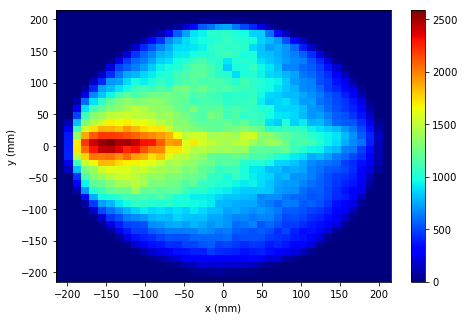

In [10]:
# Distribution in x-y
cuts_xy = C_basic
nxybins = 40

fig = plt.figure(1);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# correction factor
plt.hist2d(A_xavg[cuts_xy], A_yavg[cuts_xy], (nxybins, nxybins), ((-215, 215), (-215, 215)), cmap='jet')
plt.colorbar()
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

## Energy spectrum (double-escape peak)

/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


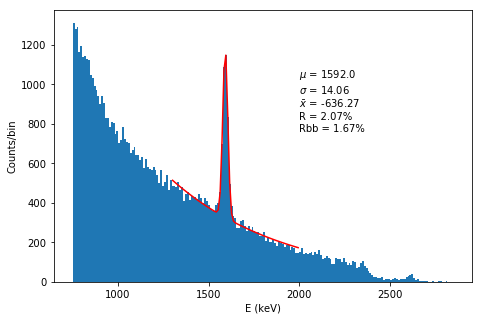

In [11]:
# Energy spectrum, focusing on double-escape peak
cuts_espec = C_wide

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y0, x0, _ = plt.hist(A_Ec[cuts_espec]*CAL_FACTOR, 200, range=[750,2850])

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, 1300, 2000)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (200, 1600, 100, 20, -600, 1200))
plt.plot(x, f.fn(x), "r")
plt.text(2000, 4*max(y)/6, gaussexpotext(f.values))

# Gaussian fit
#f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
#plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

# Energy spectrum (Cs 662 keV peak)

In [ ]:
# Energy spectrum, focusing on Cs peak
cuts_espec = C_wide

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y0, x0, _ = plt.hist(A_Ec[cuts_espec]*CAL_FACTOR, 200, range=[400,1000])

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, 650, 670)
x, y = x[sel], y0[sel]
f    = fitf.fit(fitf.gauss, x, y, (120, 640, 10))
plt.plot(x, f.fn(x), "r")
#plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))

# Gaussian fit
plt.text(700, 4*max(y)/6, gausstext(f.values))

plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

## Energy spectrum (2.6 MeV peak)

In [ ]:
# Energy spectrum, focusing on 2.6 MeV peak
cuts_peak2pt6 = C_basic

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y, x, _ = plt.hist(A_Ec[cuts_peak2pt6]*CAL_FACTOR, 100, range=[2050,2800])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

## Time evolution of energy

In [ ]:
# Energy vs. event (effectively "time")
cuts_time = C_basic

Ehist_min = 650
Ehist_max = 675
enseq = np.array(range(len(A_Ec[cuts_time])))
tprof, Eprof, Eerr = fitf.profileX(enseq,A_Ec[cuts_time]*CAL_FACTOR,nbins=8,xrange=(0,109000),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
ax1.scatter(enseq,A_Ec[cuts_time]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. event sequence number (effectively time)")
plt.ylim([550,700])
plt.xlim([0,109000])
plt.xlabel('Event')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122)
ax2.errorbar(tprof,Eprof,yerr=Eerr)
plt.title("Energy vs. event sequence # profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('Event')
plt.ylabel('E (keV)')

## Energy as a function of z

In [ ]:
# Energy vs. z
cuts_z = C_basic

Ehist_min = 645
Ehist_max = 685
zprof, Eprof, Eerr = fitf.profileX(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,nbins=8,xrange=(50,500),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. z")
plt.ylim([600,750])
plt.xlim([0,500])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(zprof,Eprof,yerr=Eerr)
plt.title("Energy vs. z profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

## Energy as a function of r

In [ ]:
# Energy vs. r
cuts_r = C_basic

Ehist_min = 650
Ehist_max = 690
rprof, Eprof, Eerr = fitf.profileX(A_ravg[cuts_r],A_Ec[cuts_r]*CAL_FACTOR,nbins=8,xrange=(0,180),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(A_ravg[cuts_r],A_Ec[cuts_r]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. r")
plt.ylim([650,690])
plt.xlim([0,200])
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(rprof,Eprof,yerr=Eerr)
plt.title("Energy vs. r profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('r (mm)')
plt.ylabel('E (keV)')

-----------------------

---------------------